In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import chromATAC as ca
from chromATAC.integrated import IntData
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from tqdm import tqdm
import warnings
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy
from chromATAC.pl import StackPlot

warnings.simplefilter("ignore", category=pd.errors.ParserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
parent_dir = '/Users/mossishahi/Code/lupien/IntData'

In [4]:
tes_dir = parent_dir+'/data/V2-TEs/non_olap'
cotes_dir = parent_dir+'/data/V2-TEs/cores1000/'

In [5]:
RES = [1e06]

def save_collision(omic, layers, coll_key, resolution=RES[0], parent="/Users/mossishahi/Code/lupien/IntData/analysis/experiment200/"):
    path = os.path.join(parent, coll_key)
    d = omic.layers[resolution][coll_key][tuple(sorted(set(layers)))][coll_key]
    if not os.path.exists(path):
        os.makedirs(path)
    for c, g in d.items():
        chromosome_name = ca.info.CHROMOSOMES['names'][c-1]
        n_hits = g['n_hits']
        n_hits.to_csv(f"{path}/{chromosome_name}__n_hits.csv")
        spcf_n_hits = g['spcf_n_hits']
        spcf_n_hits.to_csv(f"{path}/{chromosome_name}__spcf_n_hits.csv")
        mat1_spcf = g['mat1_spcf']
        mat1_spcf.to_csv(f"{path}/{chromosome_name}__spcf_CoTE.csv")
        mat2_spcf = g['mat2_spcf']
        mat2_spcf.to_csv(f"{path}/{chromosome_name}__spcf_CNV.csv")
        exp1_spcf = g['exp1_spcf']
        exp1_spcf.to_csv(f"{path}/{chromosome_name}__E_CoTE_spcf_per_hit.csv")
        exp2_spcf = g['exp2_spcf']
        exp2_spcf.to_csv(f"{path}/{chromosome_name}__E_CNV_spcf_per_hit.csv")
        pval_n_hits = g['pval_n_hits']
        pval_n_hits.to_csv(f"{path}/{chromosome_name}__pval_n_hit.csv")
        qval_n_hits = g['qval_n_hits']
        qval_n_hits.to_csv(f"{path}/{chromosome_name}__qval_n_hit.csv")
        pval_e_spcf = g['pval_e_spcf']
        pval_e_spcf.to_csv(f"{path}/{chromosome_name}__pval_e_spcf.csv")
        qval_e_spcf = g['qval_e_spcf']
        qval_e_spcf.to_csv(f"{path}/{chromosome_name}__qval_e_spcf.csv")
        with h5py.File(f"{path}/{chromosome_name}__hit_spcf.h5", 'w') as f:
            f.create_dataset('array', data=g['hit_spcf'])
        with h5py.File(f"{path}/{chromosome_name}__hit.h5", 'w') as f:
            f.create_dataset('array', data=g['hit_'])

def Clustered_TEs(chromosome_layer, **kwargs):
    resolution = kwargs.get('resolution')
    conditions = {}
    annotations = {}
    resolution = kwargs.get('resolution')
    ann = {0:'TE with no defined CORTE in any chromosome', 1:'TE with defined CORTEs'}
    for c in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in ind.chr.layers[resolution]['TEs']['index'][c]])
        conditions[c] = np.array([int(i in idx) for i in chromosome_layer['index'][c]])
        annotations[c] = ann
    return conditions, annotations

def get_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    resolution=kwargs.get('resolution')
    ann = {i:v for i, v in enumerate(tcga_met[' Project'].apply(lambda x:x.split('TCGA-')[-1]).unique())}
    mapping = {v:i for i, v in enumerate(tcga_met[' Project'].apply(lambda x:x.split('TCGA-')[-1]).unique())}
    for c in ca.info.CHROMOSOMES['numericals'].values():
        samples = chromosome_layer['index'][c]
        conditions[c] = [mapping[i.split('_')[0].split('>')[-1]] for i in ind.chr.layers[resolution]['TCGA']['index'][c]]
        annotations[c] = ann
    return conditions, annotations
    
def CTeCore_filter(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    index = kwargs.get('index')
    test_res = kwargs.get('test_res')
    maj = kwargs.get('majority', 3)
    for c in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in index[test_res[:, c-1]>=maj]])
        conditions[c] = np.array([int(i.split('>')[-1] in idx) for i in chromosome_layer['index'][c]])
        annotations[c] = ann
    return conditions, annotations

def GTeCore_filter(genome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    index = kwargs.get('index')
    test_res = kwargs.get('test_res')
    maj = kwargs.get('majority', 3)
    for c in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in index[test_res[:, c-1]>=maj]])
        conditions[c] = np.array([int(i.split('>')[-1] in idx) for i in genome_layer['index']])
        annotations[c] = ann
    return conditions, annotations

def save_correlation(omic, layers, resolution, c='all', path=".", cmp_method='sim'):
    metrs = ['score', 'pvalue']
    if c=='all':
        c=ca.info.CHROMOSOMES['names']
    if not isinstance(c, list):
        c = [c]
    for c in c:
        path = os.path.join(path, cmp_method+f'/{c}')
        if not os.path.exists(path):
            os.makedirs(path)
        for m in metrs:
            for k, v in omic.layers[resolution]['co'][tuple(sorted(set(layers)))][cmp_method][c][m].items():
                v.to_csv(f'{path}/{c}_{k}_{m}.csv')
def tcga_mapping(name):
    return f"{tcga_met.iloc[np.where([i in name for i in tcga_met['File Name'].apply(lambda x: x.split('_')[0].split('-')[-1])])[0]][' Project'].apply(lambda x:x.split('TCGA-')[-1]).values[0]}_{name}"
    
def TE_family(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {i:te.split('>')[-1] for i, te in enumerate(ind.chr.layers[1e06]['TEs']['index'][1])}
    con = {te.split('>')[-1]:i for i, te in enumerate(ind.chr.layers[1e06]['TEs']['index'][1])}
    for c in range(1, 25):
        conditions[c] = np.array([con[i.split('>')[-1]] for i in chromosome_layer['index'][c]])
        annotations[c] = ann
    return conditions, annotations
    
def Cnv_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {i:cancer for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    con =  {cancer:i for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    for c in tqdm(range(1, 25)):
        samples = chromosome_layer['index'][c]
        conditions[c] = np.array([con[cnv_meta.iloc[np.where(cnv_meta['name']==sample.split('.bed')[0].split(">")[-1])[0]]['cancer_type'].values.item()] for sample in samples if sample.split(">")[-1] in cnv_meta['name'].values])
        annotations[c] = ann
    return conditions, annotations
    
def cnv_gain(matrix, **kwargs):
    m = matrix.copy()
    m[m<=2]=0
    return m
    
def cnv_loss(matrix, **kwargs):
    m = matrix.copy()
    chr = kwargs.get('chr')
    m[m>=2]=0
    return m
    
def normalize_cotes(matrix, **kwargs):
    index = kwargs.get('index')
    df = n_cotes.reindex([i.split('CoTEs>')[-1] for i in index])
    v = df['n_cotes'].values
    m = matrix/v[:, np.newaxis]
    return m
    
def cnv_class_filter(row, **kwargs):
    index_col=kwargs.get('index_col')
    return bool(sample_sig.loc[row.iloc[index_col], row.loc['CN']])

def tcga_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    resolution=kwargs.get('resolution')
    ann = {i:v for i, v in enumerate(tcga_meta[' Project'].apply(lambda x:x.split('TCGA-')[-1]).unique())}
    mapping = {v:i for i, v in enumerate(tcga_meta[' Project'].apply(lambda x:x.split('TCGA-')[-1]).unique())}
    df = tcga_meta.reindex([x.split('_')[0].split('-')[-1] for x in tcga_samples['samples']])
    for chr in ca.info.CHROMOSOMES['numericals'].values():
        samples = [i.split('>')[-1] for i in chromosome_layer['index'][chr]]
        conditions[chr] = df.loc[samples][' Project'].apply(lambda x: mapping[x.split('-')[-1]]).values
        annotations[chr] = ann
    return conditions, annotations
    
def tcga_mapping(name):
    return f"{tcga_met.iloc[np.where([i in name for i in tcga_met['File Name'].apply(lambda x: x.split('_')[0].split('-')[-1])])[0]][' Project'].apply(lambda x:x.split('TCGA-')[-1]).values[0]}_{name}"

In [6]:
def Cnv_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {i:cancer for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    con =  {cancer:i for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    for c in tqdm(range(1, 25)):
        samples = chromosome_layer['index'][c]
        conditions[c] = np.array([con[cnv_meta.iloc[np.where(cnv_meta['name']==sample.split('.bed')[0].split(">")[-1])[0]]['cancer_type'].values.item()] for sample in samples if sample.split(".")[0].split(">")[-1] in cnv_meta['name'].values])
        annotations[c] = ann
    return conditions, annotations
def cnv_class_filter(row, **kwargs):
    index_col=kwargs.get('index_col')
    return bool(sample_sig.loc[row.iloc[index_col], row.loc['CN']])

te_dir = parent_dir+'/data/V2-TEs/non_olap'
cote_dir = parent_dir+'/data/V2-TEs/cores1000'

In [7]:
def TE_family(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {i:te.split('>')[-1] for i, te in enumerate(ind.chr.layers[1e06]['TEs']['index'][1])}
    con = {te.split('>')[-1]:i for i, te in enumerate(ind.chr.layers[1e06]['TEs']['index'][1])}
    for chr in range(1, 25):
        conditions[chr] = np.array([con[i.split('>')[-1]] for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

In [8]:
def CoTE_family(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {i:te.split('>')[-1] for i, te in enumerate(ind.chr.layers[1e06]['CoTEs']['index'][1])}
    con = {te.split('>')[-1]:i for i, te in enumerate(ind.chr.layers[1e06]['CoTEs']['index'][1])}
    for chr in range(1, 25):
        conditions[chr] = np.array([con[i.split('>')[-1]] for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

In [9]:
ind = IntData()
ind.add_layer("TEs", input=te_dir, index_mapper=lambda x: x.split("_Merged.bed")[0], resolutions=[1e6])
ind.add_layer("CoTEs", input=cote_dir, index_mapper=lambda x: x.split("_Merged.bed")[0], resolutions=[1e06])

loading files from: /Users/mossishahi/Code/lupien/IntData/data/V2-TEs/non_olap


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 975/975 [00:09<00:00, 108.25it/s]


loading files from: /Users/mossishahi/Code/lupien/IntData/data/V2-TEs/cores1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 456/456 [00:00<00:00, 1207.98it/s]


In [82]:
ind.add_layer("TCGA",  resolutions=[1e06], 
              input=parent_dir+'/data/TCGA/filtered_TCGA', 
              index_mapper=lambda x: x.split('_')[0].split('-')[-1],
             feature_type='signal',
             overlap_method='max',
             feature_column=4)

loading files from: /Users/mossishahi/Code/lupien/IntData/data/TCGA/filtered_TCGA


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [03:27<00:00,  2.09it/s]


In [83]:
files = [i.split('_peaks.')[0] for i in os.listdir(parent_dir+'/data/TCGA/filtered_TCGA/') if i.endswith('.bed')]

In [84]:
tcga_meta = pd.read_csv(parent_dir+'/data/TCGA/GDC_identifiers_no_duplicates.tsv', sep='\t')
tcga_samples = pd.DataFrame(files, columns=['samples'])
tcga_meta['id'] = tcga_meta['File Name'].apply(lambda x: x.split('_')[0].split('-')[-1])
tcga_meta = tcga_meta.set_index('id')
df=tcga_meta.reindex([x.split('_')[0].split('-')[-1] for x in tcga_samples['samples']])

In [85]:
ind.chr.add_filter('Cancertype', tcga_cancertype, ['TCGA'], resolutions=[1e06])

In [86]:
CHROM = 'chr7'
CAN = 'GBM'
qVAL = .05
RES = [1e06]

In [87]:
ind.chr.add_filter('te_family', TE_family, ['TEs'])
ind.chr.add_filter('cote_family', CoTE_family, ['CoTEs'])

In [88]:
TEs = np.array([i.split('.')[0] for i in os.listdir(tes_dir) if i.endswith('.bed')])
COTEs = np.array([i.split('.')[0] for i in os.listdir(cotes_dir) if i.endswith('.bed')])

In [89]:
te_meta = pd.read_csv(parent_dir+'/analysis/data/repeat_metadata.onlyTEs_full.tsv', sep='\t')
te_df = te_meta.iloc[np.concatenate([np.where(te_meta['repname_numbered'].apply(lambda x: i.split('_')[0]==x.split('_')[0]))[0] for i in TEs]), :].loc[:, ['repname', 'Superfamily', 'repname_numbered']].copy()
te_df.index = range(1, len(te_df)+1)
te_df['COTE'] = te_df['repname_numbered'].apply(lambda x: x.split('_')[0] in np.array([i.split('_')[0] for i in np.intersect1d(TEs, COTEs)]))
te_df.loc[971] = ['ERV3-16A3_I-int', 'ERVL', '369_ERV3-16A3_I-int', True]

In [90]:
te_n_elements = pd.read_csv(tes_dir+'/n_elements_per_TE.tsv', sep='\t', header=None, names = ['name', 'n_elements'])
cote_n_elments = pd.read_csv(cotes_dir+'/n_clusters_per_TE.tsv', sep='\t', header=None, names = ['name', 'n_clusters'])

In [91]:
te_n_elements['name'] = te_n_elements['name'].apply(lambda x: x.split('_Merged.bed')[0])
cote_n_elments['name'] = cote_n_elments['name'].apply(lambda x: x.split('_Merged.bed')[0])
te_df = te_df.merge(te_n_elements, how='left', left_on='repname_numbered', right_on='name').merge(cote_n_elments, how='left', left_on='repname_numbered', right_on='name').drop(['name_x', 'name_y'], axis=1).fillna(0)
te_df.set_index('repname_numbered', inplace=True)

In [92]:
def tcga_to_cote(CAN, CHROM, parent_dir, fig_dir=None, show_plot=True, exp=100):
    df1 = pd.read_csv(parent_dir+f'/analysis/experiment{exp}/gain/{CHROM}__n_hits.csv')
    df1.rename({'Unnamed: 0': 'TE'}, axis=1, inplace=True)
    df1['TE'] = df1['TE'].apply(lambda x: x.split('>')[-1])
    df1 = df1.set_index('TE')
    
    df1 = df1.sort_values(f'TCGA;Cancertype:{CAN}', ascending=False)
    
    qval = pd.read_csv(parent_dir+f'/analysis/experiment{exp}/gain/{CHROM}__qval_n_hit.csv')
    qval.rename({'Unnamed: 0': 'TE'}, axis=1, inplace=True)
    qval['TE'] = qval['TE'].apply(lambda x: x.split('>')[-1])
    qval = qval.set_index('TE')
    df2 = qval.sort_values(f'TCGA;Cancertype:{CAN}').loc[:,f'TCGA;Cancertype:{CAN}']
    candidates = df1[qval.reindex_like(df1).loc[:,f'TCGA;Cancertype:{CAN}']<=qVAL].index
    
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(len(candidates)+2, 1, figsize=(24, 3*len(candidates)), sharex=True)
    axs = axs.flatten()
    c = ind.chr.get_layer('TCGA',
                  chrom=CHROM,
                  groups={'Cancertype':CAN},
                 )[f'Cancertype:{CAN}']
    c_data = c['data']
    sns.lineplot(c_data.mean(0), ax=axs[0], color='navy')
    sns.barplot(100*(c_data>0).sum(0)/c_data.shape[0], ax=axs[1], color='skyblue', alpha=.4)
    axs[0].set_ylabel('Average of Chromatin Accessibiliy', fontsize=8)
    axs[1].set_ylabel('Samples with CN alteration (%)', fontsize=8)
    
    for i, candidate in enumerate(candidates):
        ct = ind.chr.get_layer('CoTEs',
                          chrom=CHROM,
                          groups={'cote_family':candidate},
                         )[f'cote_family:{candidate}']
        ct_data = ct['data']
        ax = axs[i+2]
        bins = np.arange(ca.info.CHROMOSOMES['lens'][CHROM]/RES[0])
        sns.lineplot(ct_data.mean(0), ax=ax, color='orange')
        ax.set_xticks(bins)
        ax.set_xticklabels(np.arange(1, len(bins) + 1), rotation=90, fontsize=8)
        ax.set_xlabel(f'Chromosome {CHROM.split('chr')[-1]} -  Mega base pairs', fontsize=16)
        ax.set_ylabel(f'{candidate}', fontsize=10)
    plt.subplots_adjust(hspace=0.2)
    plt.suptitle(f'Co occurnces of Copy Number Alteration in cancer type: {CAN} and CoTEs from {candidate} TE family', y=.89)
    if show_plot:
        plt.show()
    # path = fig_dir + f'/{CAN}/' + f'{CHROM}/'
    # if not os.path.exists(path):
    #     os.makedirs(path)
    # fig.savefig(path+f'{CHROM}.png')
    # print(f'fig saved at {path}')

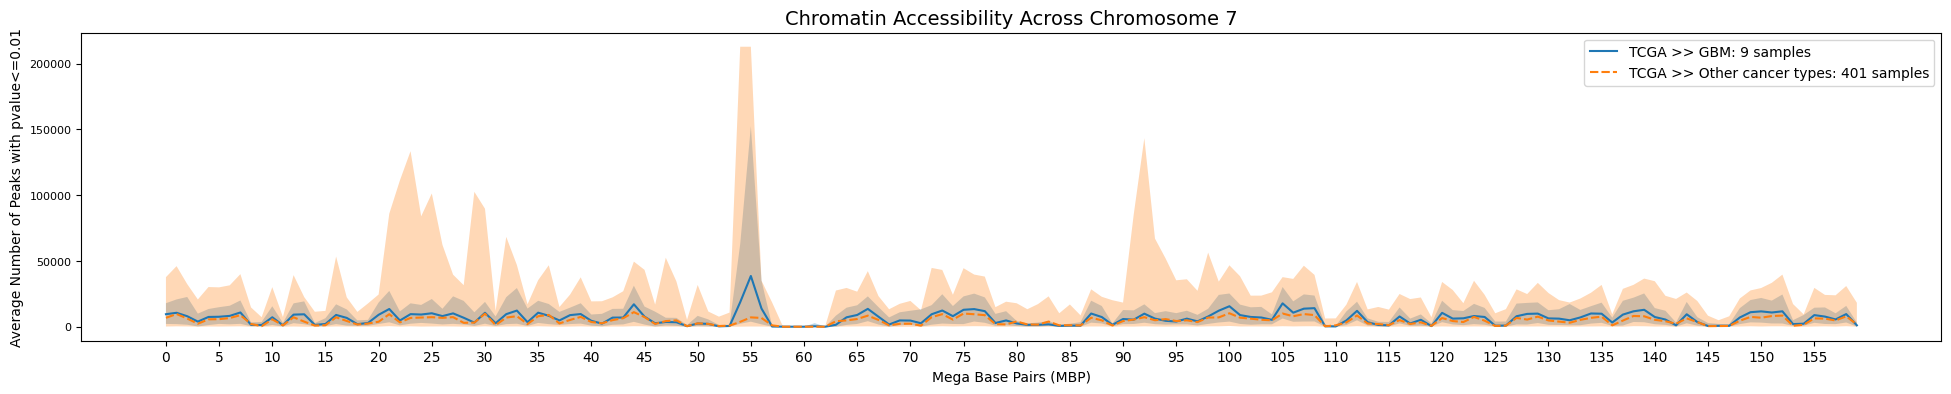

In [93]:
f = ind.chr.get_layer('TCGA', groups={'Cancertype':CAN}, chrom=CHROM)
d = f[f'Cancertype:{CAN}']['data']
min_d = d.min(0)
max_d = d.max(0)
nf = ind.chr.get_layer('TCGA', groups={'Cancertype':CAN}, chrom=CHROM, reverse_filter=True)
nd = nf[f'Cancertype:{CAN}']['data']
min_nd = nd.min(0)
max_nd = nd.max(0)

# ef = ind.chr.get_layer('ENCODE', groups={'biosample':'breast epithelium'}, chrom='chr17')
# ed = ef['biosample:breast epithelium']['data']

df = pd.DataFrame(np.vstack([d.mean(0).T, nd.mean(0).T]),
                  index=[f'TCGA >> {CAN}: {d.shape[0]} samples', f'TCGA >> Other cancer types: {nd.shape[0]} samples']).T
plt.figure(figsize=(24, 4))
plt.title(f'Chromatin Accessibility Across Chromosome {CHROM.split('chr')[-1]}', fontsize=14)
plt.xlabel('Mega Base Pairs (MBP)')
plt.ylabel('Average Number of Peaks with pvalue<=0.01')
plt.xticks(np.arange(0, d.shape[1], 5))
plt.yticks(fontsize=8)
sns.lineplot(df)
plt.fill_between(range(d.shape[1]), min_d, max_d, alpha=0.3, label='Range d')
plt.fill_between(range(nd.shape[1]), min_nd, max_nd, alpha=0.3, label='Range nd')
plt.savefig(f'{CAN}vs_others_atac_TCGA-{CHROM}.png', bbox_inches='tight')
plt.show()

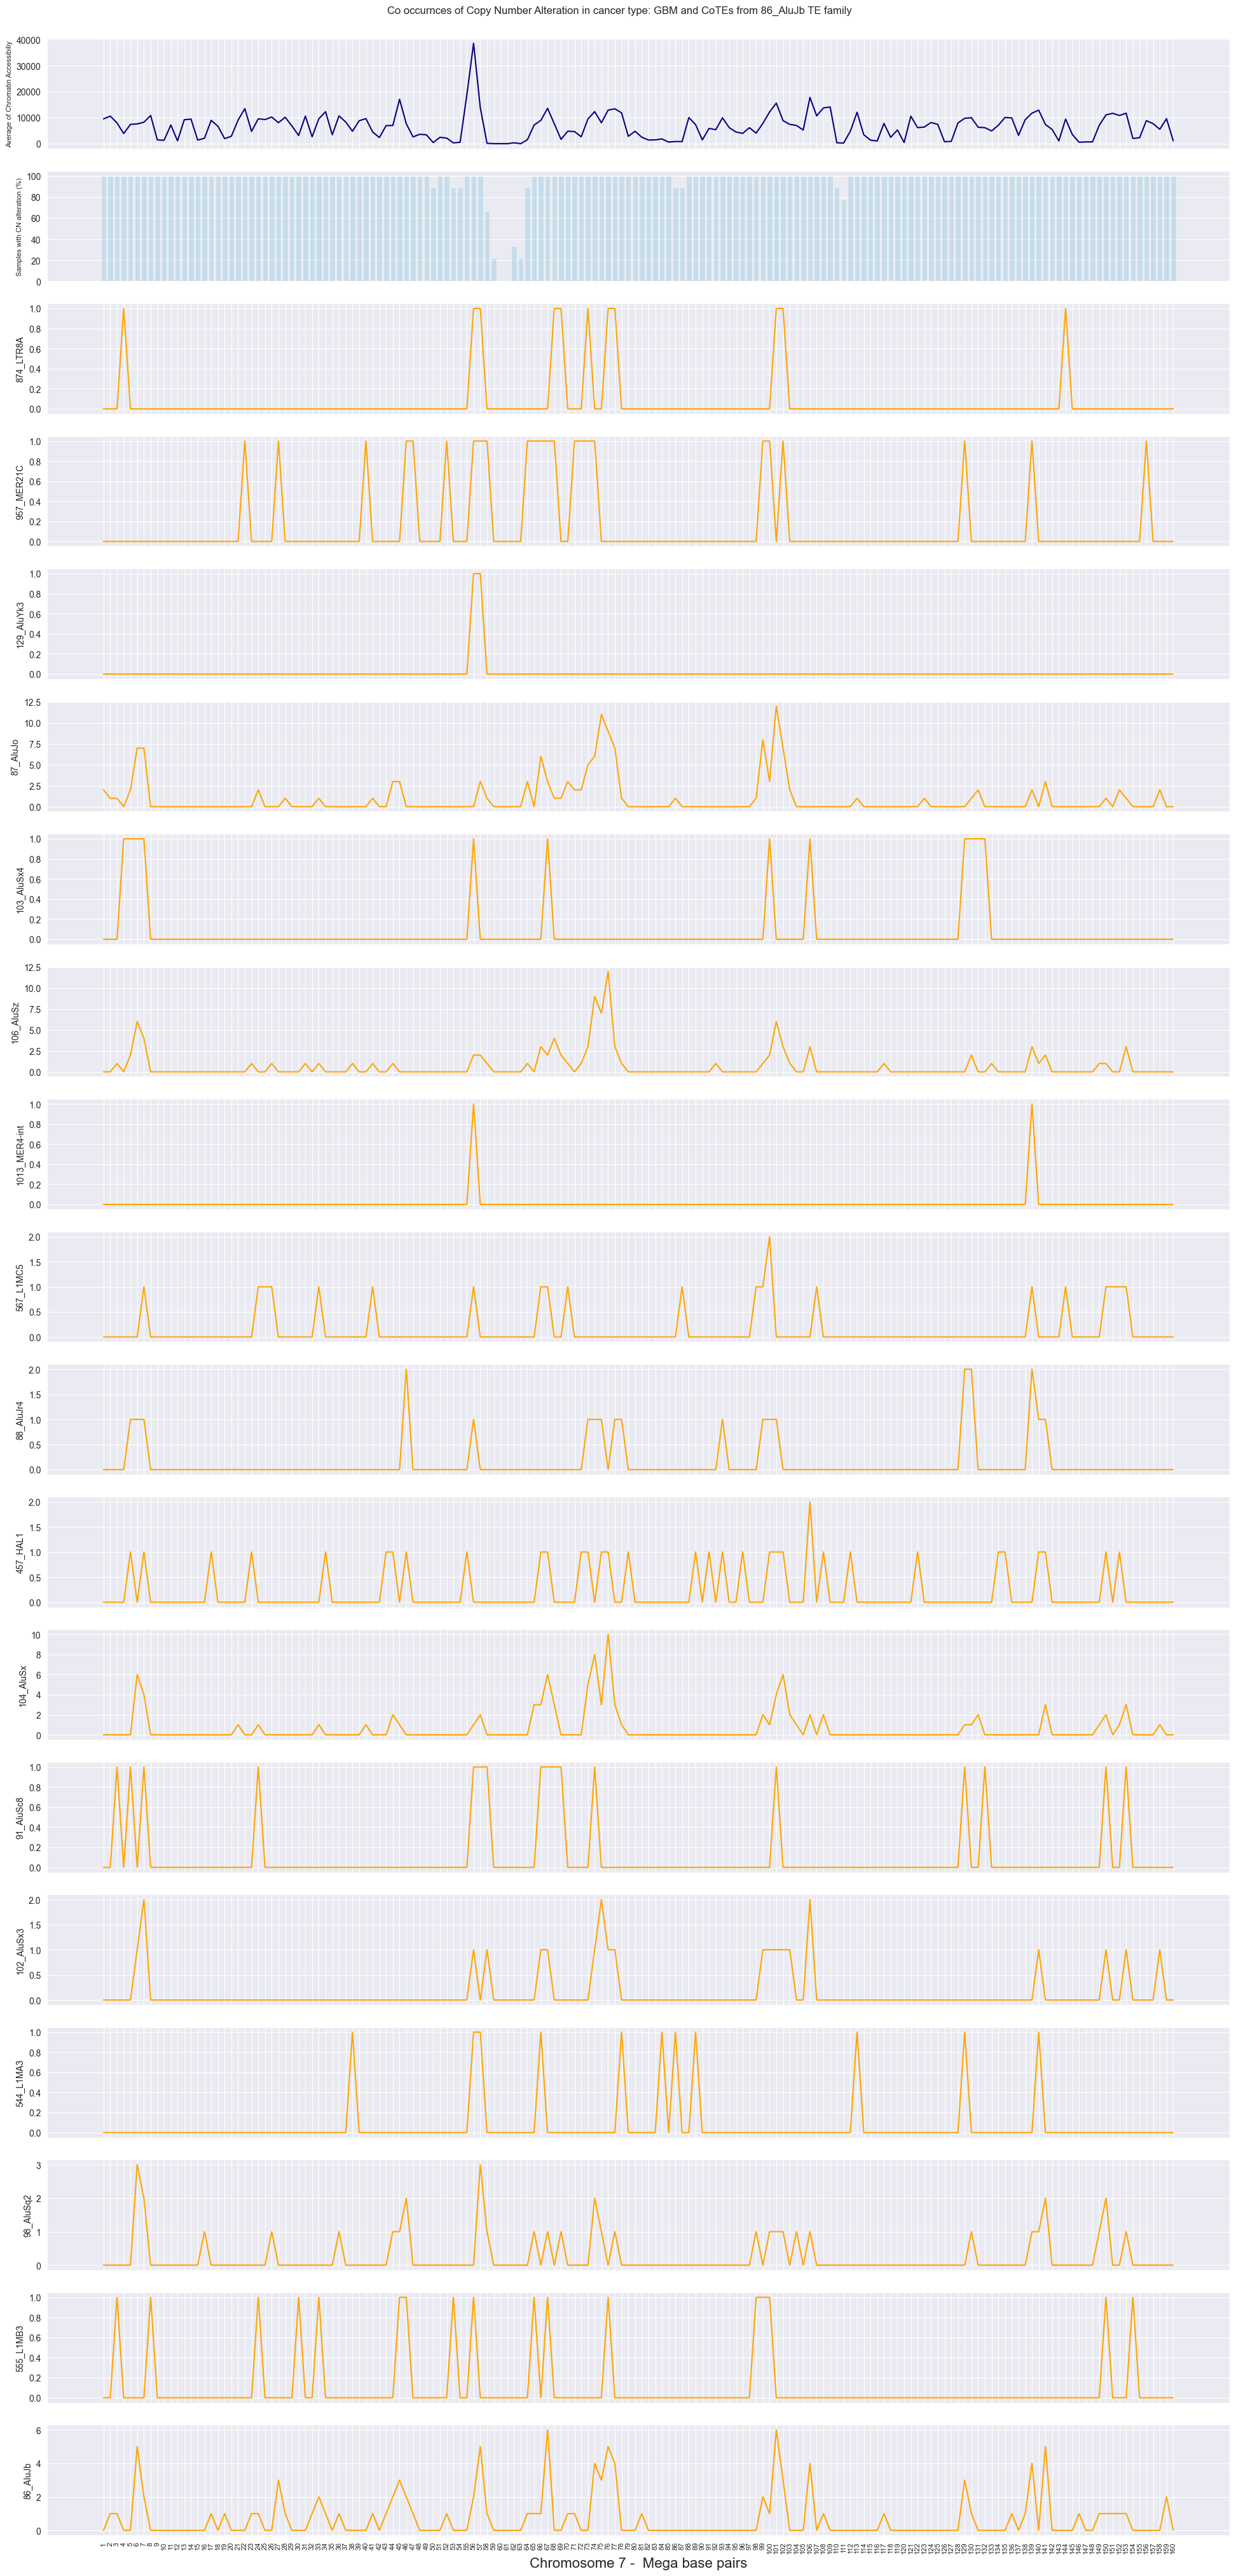

In [94]:
tcga_to_cote('GBM', 'chr7', exp=200, parent_dir=parent_dir)

In [324]:
def plot_grouped_data_with_stackplot(df, fig_width,fig_height, shade, super_title, super_title_fontsize=16, tick_label_fontsize=10, palette=None):
    # Ensure data is numeric
    df.iloc[:, :-1] = df.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')

    # Check for NaN values in the DataFrame
    if df.isnull().values.any():
        print("Warning: NaN values detected in the DataFrame")

    # Group and sort data
    grouped = df.groupby('cancertype')
    track_heights = grouped.max().max(axis=1)
    sorted_groups = track_heights.sort_values(ascending=True).index.tolist()

    # Calculate the total sum of track heights and the relative heights
    total_height_sum = track_heights.sum()
    relative_heights = [track_height / total_height_sum for track_height in track_heights[sorted_groups]]
    # Initialize StackPlot
    stack_plot = StackPlot(figsize=(fig_width, fig_height), super_title=super_title, palette=palette)
    # Add tracks and plot data
    accumulated_relative_height = 0
    for i, cancer_type in enumerate(sorted_groups):
        relative_track_height = relative_heights[i]
        span_start = accumulated_relative_height
        span_end = accumulated_relative_height + relative_track_height
        accumulated_relative_height = span_end

        # Convert relative span to actual height
        actual_span = (span_start, span_end)

        track = stack_plot.add_track(actual_span, cancer_type)
        group_data = grouped.get_group(cancer_type)
        mean = group_data.iloc[:, :-1].mean()
        max_val = group_data.iloc[:, :-1].max()
        min_val = group_data.iloc[:, :-1].min()

        # Check if index needs to be converted to numeric
        if not np.issubdtype(mean.index.dtype, np.number):
            try:
                mean.index = pd.to_numeric(mean.index)
            except:
                pass  # Keep the original index if conversion fails
        track.lineplot(mean)
        track.add_label(cancer_type, side='right')
        if shade:
            track.fill_between(mean.index, min_val, max_val, alpha=0.3)

    # Render the plot
    stack_plot.render(grid=False)

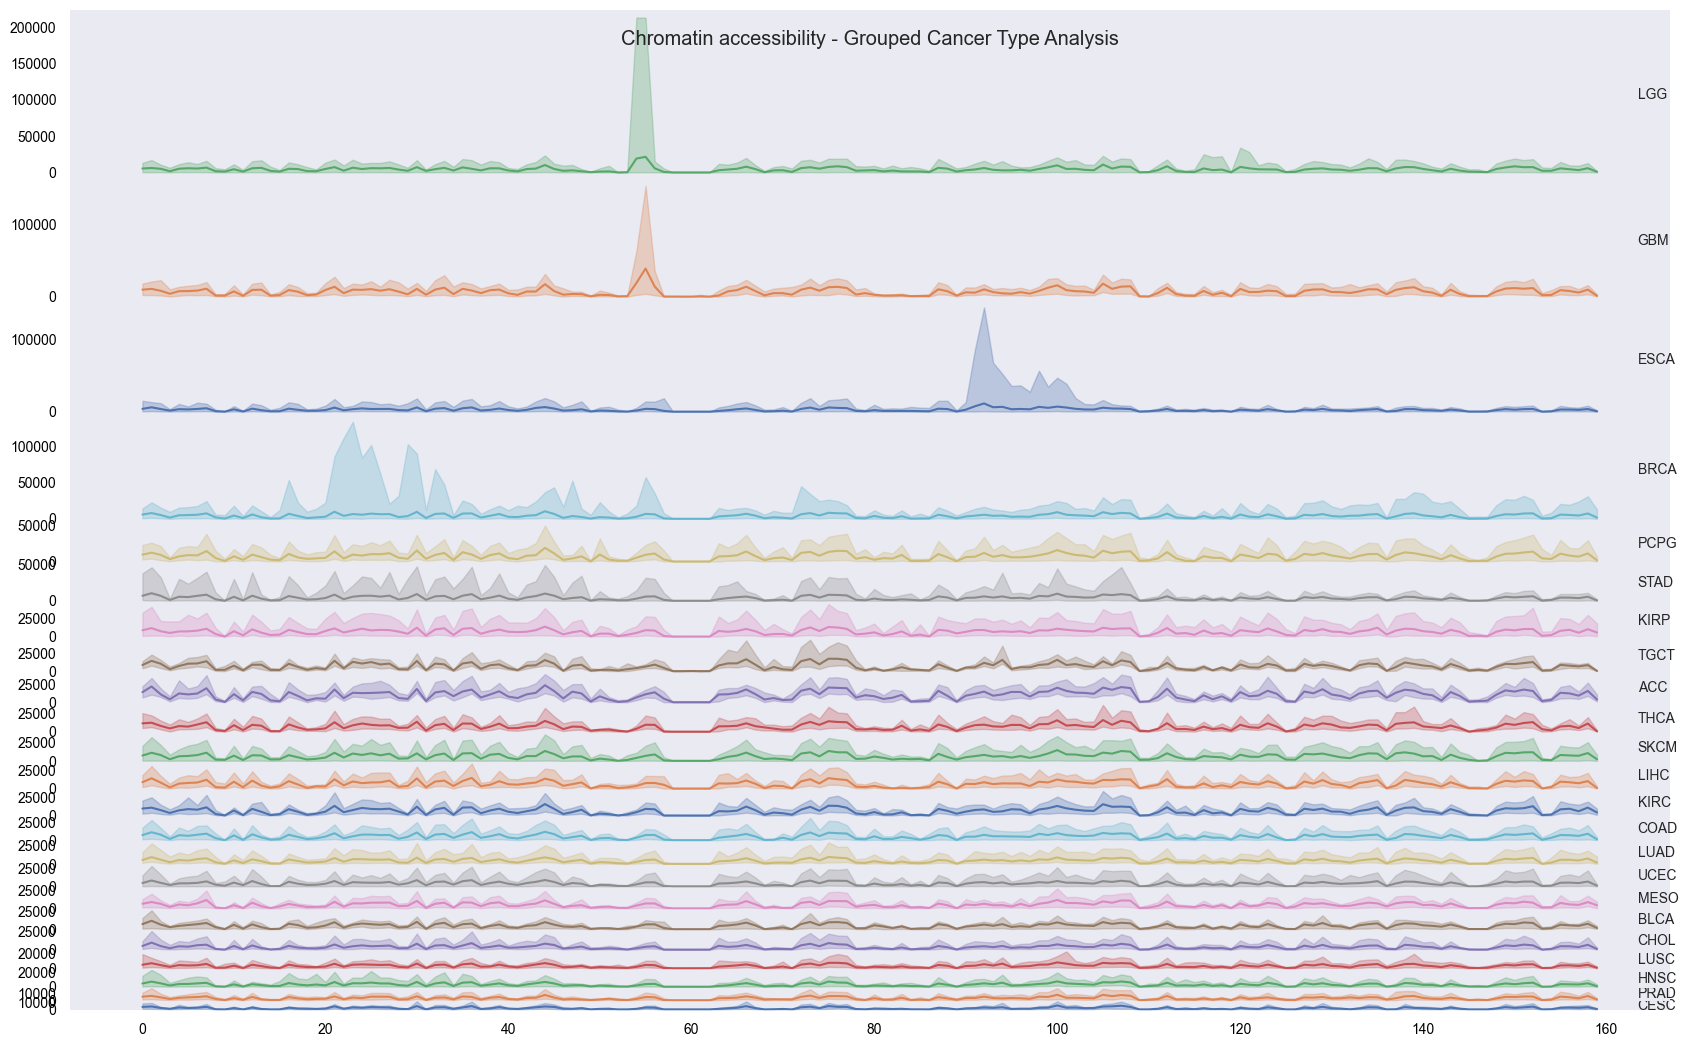

In [361]:
# Example usage
plot_grouped_data_with_stackplot(df, fig_width=20, fig_height=10, shade=True, super_title="Chromatin accessibility - Grouped Cancer Type Analysis", super_title_fontsize=18, tick_label_fontsize=12)

In [99]:
n_cotes = pd.read_csv(cote_dir+'/n_clusters_per_TE.tsv', sep='\t', names=['TE', 'n_cotes'])
n_cotes['TE'] = n_cotes['TE'].apply(lambda x: x.split('_Merged')[0])
n_cotes = n_cotes.set_index('TE')

In [126]:
ind.chr.collide_layers(['CoTEs', 'TCGA'], 
                       resolution=RES[0], 
                       groups={'TCGA':{'Cancertype':list(tcga_meta[' Project'].apply(lambda x: x.split('TCGA-')[-1]).unique())}}, 
                       kernels = {'CoTEs':normalize_cotes}, 
                       coll_key='gain', 
                       classifier=lambda x: 'TCGA' in x, by={'TCGA':'group', 'CoTEs':'sample'})